# KAGGLE 

https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction

In [1]:
import torch
import os
import pandas as pd
import torch.optim as optim
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                 "../")
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [2]:
#run this cell once per paperspace session
import kaggle_utils as ku
ku.setup_all(data_dir='datap', competition_name='amp-parkinsons-disease-progression-prediction')

setup environment...
Setup python packages...


--2023-05-08 01:48:15--  https://raw.githubusercontent.com/kperkins411/dotfiles/master/setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1180 (1.2K) [text/plain]
Saving to: ‘setup.sh’

     0K .                                                     100% 21.7M=0s

2023-05-08 01:48:16 (21.7 MB/s) - ‘setup.sh’ saved [1180/1180]

Cloning into '/root/.cfg1'...


Running setup.sh...


rm: cannot remove '/root/.vimrc': No such file or directory
cp: cannot stat '/root//.vimrc': No such file or directory
rm: cannot remove '/root/.tmux.conf': No such file or directory
cp: cannot stat '/root//.tmux.conf': No such file or directory
rm: cannot remove '/root/.ctags': No such file or directory
cp: cannot stat '/root//.ctags': No such file or directory
cp: cannot stat '/root//.gitconfig': No such file or directory
rm: cannot remove '/root/.bash_aliases': No such file or directory
cp: cannot stat '/root//.bash_aliases': No such file or directory


Removing /.vimrc
Copying .vimrc to .cfg1
Removing /.tmux.conf
Copying .tmux.conf to .cfg1
Removing /.ctags
Copying .ctags to .cfg1
Removing /.gitconfig
Copying .gitconfig to .cfg1
Removing /.bash_aliases
Copying .bash_aliases to .cfg1
Changing key permissions...
setup data...


100%|██████████| 16.1M/16.1M [00:00<00:00, 52.4MB/s]


In [3]:
import utils_parkinsons as pu
df_train_cli = pd.read_csv(pu.CFG.DATAP+"train_clinical_data.csv")
df_train_pep = pd.read_csv(pu.CFG.DATAP+"train_peptides.csv")
df_train_pro = pd.read_csv(pu.CFG.DATAP+"train_proteins.csv")

In [4]:
print(f'df_train_cli={df_train_cli.shape}, df_train_pep={df_train_pep.shape},df_train_pro={df_train_pro.shape}') 

df_train_cli=(2615, 8), df_train_pep=(981834, 6),df_train_pro=(232741, 5)


In [5]:
df_train_cli.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [6]:
df_train_cli.nunique()

visit_id                               2615
patient_id                              248
visit_month                              17
updrs_1                                  32
updrs_2                                  36
updrs_3                                  72
updrs_4                                  19
upd23b_clinical_state_on_medication       2
dtype: int64

In [7]:
df_train_pep.nunique()

visit_id              1113
visit_month             15
patient_id             248
UniProt                227
Peptide                968
PeptideAbundance    738931
dtype: int64

In [8]:
df_train_pro.nunique()

visit_id         1113
visit_month        15
patient_id        248
UniProt           227
NPX            218795
dtype: int64

In [9]:
df_train_cli.visit_month.unique()

array([  0,   3,   6,   9,  12,  18,  24,  30,  36,  42,  48,  54,  60,
        72,  84,  96, 108])

In [10]:
df_train_pep.visit_month.unique()

array([  0,   3,   6,  12,  18,  24,  30,  36,  48,  54,  60,  72,  84,
        96, 108])

In [11]:
df_train_pro.visit_month.unique()

array([  0,   3,   6,  12,  18,  24,  30,  36,  48,  54,  60,  72,  84,
        96, 108])

In [12]:
#what is is cli but not others
oddities=[a for a in df_train_cli.visit_month.unique() if a not in df_train_pro.visit_month.unique()]
oddities

[9, 42]

In [13]:
df_train_cli.upd23b_clinical_state_on_medication.value_counts()

On     775
Off    513
Name: upd23b_clinical_state_on_medication, dtype: int64

In [14]:
df_train_cli.upd23b_clinical_state_on_medication.isnull().sum()

1327

In [15]:
df_train_cli[df_train_cli['visit_month'] ==42]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
9,55_42,55,42,12.0,20.0,41.0,0.0,On
21,942_42,942,42,2.0,3.0,32.0,0.0,NaN
35,1517_42,1517,42,15.0,13.0,37.0,4.0,On
60,3636_42,3636,42,10.0,9.0,12.0,0.0,On
72,3863_42,3863,42,15.0,16.0,25.0,5.0,On
...,...,...,...,...,...,...,...,...
2557,63875_42,63875,42,4.0,1.0,1.0,0.0,NaN
2565,63889_42,63889,42,5.0,5.0,27.0,1.0,Off
2578,64669_42,64669,42,20.0,18.0,49.0,0.0,On
2593,64674_42,64674,42,5.0,18.0,48.0,2.0,NaN


In [16]:
#how many have NaNs and also On and Off in upd23b_clinical_state_on_medication
df_train_cli.groupby('patient_id')['upd23b_clinical_state_on_medication'].nunique()

patient_id
55       1
942      1
1517     2
1923     0
2660     0
        ..
63875    0
63889    2
64669    2
64674    2
65043    2
Name: upd23b_clinical_state_on_medication, Length: 248, dtype: int64

In [32]:
df_train_cli[df_train_cli['patient_id'] ==63889]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
2559,63889_0,63889,0,7.0,3.0,30.0,0.0,Off
2560,63889_12,63889,12,8.0,10.0,21.0,3.0,Off
2561,63889_18,63889,18,8.0,6.0,3.0,NaN,NaN
2562,63889_24,63889,24,8.0,2.0,7.0,2.0,On
2563,63889_30,63889,30,8.0,4.0,17.0,0.0,Off
2564,63889_36,63889,36,8.0,3.0,18.0,1.0,Off
2565,63889_42,63889,42,5.0,5.0,27.0,1.0,Off
2566,63889_48,63889,48,5.0,8.0,10.0,2.0,On
2567,63889_54,63889,54,5.0,9.0,26.0,3.0,On
2568,63889_60,63889,60,6.0,5.0,28.0,2.0,Off


In [33]:
df_train_cli[df_train_cli['patient_id'] ==64669]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
2569,64669_0,64669,0,12.0,14.0,27.0,NaN,NaN
2570,64669_3,64669,3,15.0,16.0,29.0,NaN,NaN
2571,64669_6,64669,6,17.0,20.0,33.0,NaN,NaN
2572,64669_9,64669,9,12.0,16.0,17.0,0.0,On
2573,64669_12,64669,12,12.0,9.0,17.0,0.0,On
2574,64669_18,64669,18,15.0,13.0,20.0,0.0,On
2575,64669_24,64669,24,19.0,17.0,25.0,0.0,On
2576,64669_30,64669,30,20.0,13.0,38.0,0.0,On
2577,64669_36,64669,36,23.0,18.0,53.0,0.0,Off
2578,64669_42,64669,42,20.0,18.0,49.0,0.0,On


In [28]:
df_train_cli[df_train_cli['patient_id'] ==942]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
13,942_0,942,0,3.0,2.0,20.0,NaN,NaN
14,942_3,942,3,7.0,2.0,17.0,NaN,NaN
15,942_6,942,6,8.0,2.0,21.0,NaN,NaN
16,942_12,942,12,5.0,2.0,25.0,0.0,NaN
17,942_18,942,18,6.0,5.0,18.0,0.0,NaN
18,942_24,942,24,2.0,3.0,23.0,NaN,NaN
19,942_30,942,30,4.0,4.0,19.0,0.0,NaN
20,942_36,942,36,2.0,4.0,19.0,0.0,NaN
21,942_42,942,42,2.0,3.0,32.0,0.0,NaN
22,942_48,942,48,2.0,6.0,35.0,0.0,NaN


In [40]:
dft=df_train_cli[df_train_cli['updrs_4'].isna()]
print(dft.upd23b_clinical_state_on_medication.value_counts())
print(dft.upd23b_clinical_state_on_medication.isna().sum())

On     15
Off     7
Name: upd23b_clinical_state_on_medication, dtype: int64
1016


## Start cleaning

In [41]:
df_train_cli.isnull().sum()

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64

In [42]:
#outcomes
df_train_cli[df_train_cli.updrs_1.isna()]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
1827,45181_42,45181,42,NaN,NaN,0.0,NaN,NaN


In [43]:
df_train_cli[df_train_cli.patient_id==45181]

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
1823,45181_0,45181,0,5.0,0.0,2.0,NaN,NaN
1824,45181_6,45181,6,6.0,0.0,4.0,NaN,NaN
1825,45181_12,45181,12,9.0,0.0,1.0,NaN,NaN
1826,45181_24,45181,24,7.0,0.0,1.0,NaN,NaN
1827,45181_42,45181,42,NaN,NaN,0.0,NaN,NaN
1828,45181_48,45181,48,2.0,0.0,4.0,NaN,NaN


## Visualize some outcomes

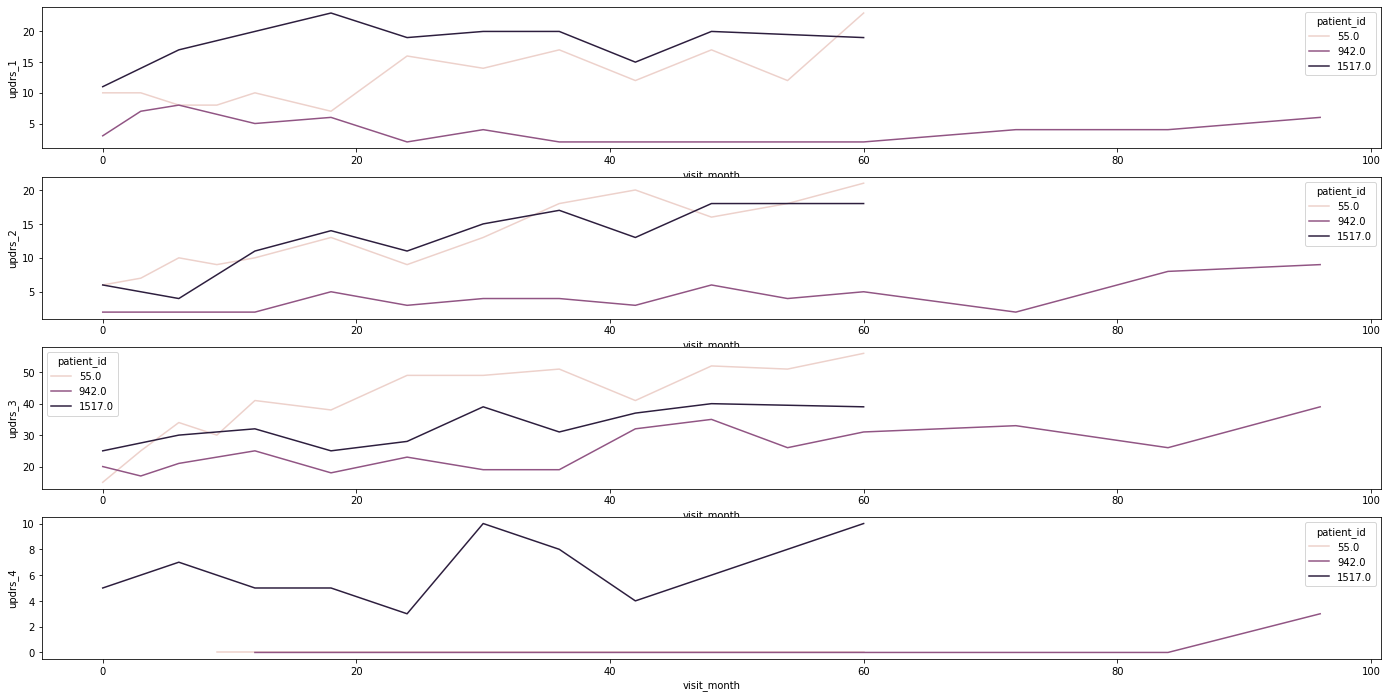

In [22]:
fig, ax1 = plt.subplots(*(4,1),figsize=(24,12))
updirs=['updrs_1','updrs_2','updrs_3','updrs_4']
for i,ud in enumerate(updirs):
    _=sns.lineplot(data=df_train_cli[df_train_cli.patient_id.isin(patients[:3])], x=df_train_cli.visit_month, y=ud,hue='patient_id',ax=ax1[i],legend='full')

## Are there any corelations?


In [23]:
import pandas as pd
import numpy as np
def impute_NaNs(df, strategy='most_frequent',verbose=True):
    '''
    use simple imputer to replace NaNs
    df: dataframe to operate on
    return: transformed df
    '''
    #are there any?
    nans=df.isnull().sum()
    tot=nans.sum()
    if tot==0:
        return df
    
    if verbose == True:
        print(f'Fixing {tot} NaNs using {strategy} strategy')
 
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)  #works with strings
    nans=[nans.index[i] for i,val in enumerate(nans) if val>0]   
    for val in nans:        
        imp = imp.fit(df[[val]])  #determine replacement  
        df[[val]]=imp.transform(df[[val]])  #here is where the transform is applied 
    return df

#find extra correlated columns
def get_correlated_columns(df,correlation_threshold=.95):
    '''
    df: a dataframe
    correlation_threshold: select all rows and columns that have a correlation >= to this value
    return: list of tuples of form [ (col,row),...]
    '''
    # generate the correlation matrix (abs converts to absolute value, this way we only look for 1 color range)
    corr = df.corr().abs()
    # Generate mask for the upper triangle (see https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
    # the matrix is symmetric, the diagonal (all 1's) and upper triangle are visual noise, use this to mask both out
    mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)    #k=-1 means get rid of the diagonal
    corr = corr.where(cond=mask)
    
    correlated=[]
    for col in corr.columns:
        for i,val in enumerate(corr.loc[col]):
            if( val>= correlation_threshold):
                correlated.append((col,corr.loc[col].index[i]))
    return correlated

In [27]:
 get_correlated_columns(df_train_cli, correlation_threshold=.65)

[('updrs_2', 'updrs_1'), ('updrs_3', 'updrs_2')]

## add a time treated feature